In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###Importation des données

In [ ]:
trainfeatures_df=pd.read_csv('/content/dengue_features_train.csv')

In [ ]:
trainlabels_df = pd.read_csv('/content/dengue_labels_train.csv')

In [ ]:
trainlabels_df = trainlabels_df.drop(['city','year','weekofyear'],axis=1)

In [ ]:
df_train = pd.concat([trainfeatures_df,trainlabels_df],axis=1)
df_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


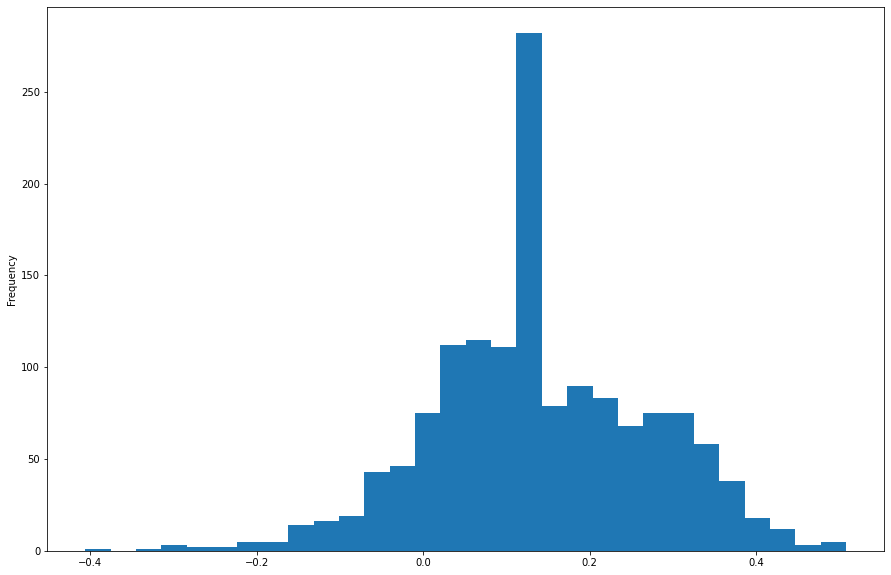

In [ ]:
df_train['ndvi_ne'].plot(kind="hist", bins=30)

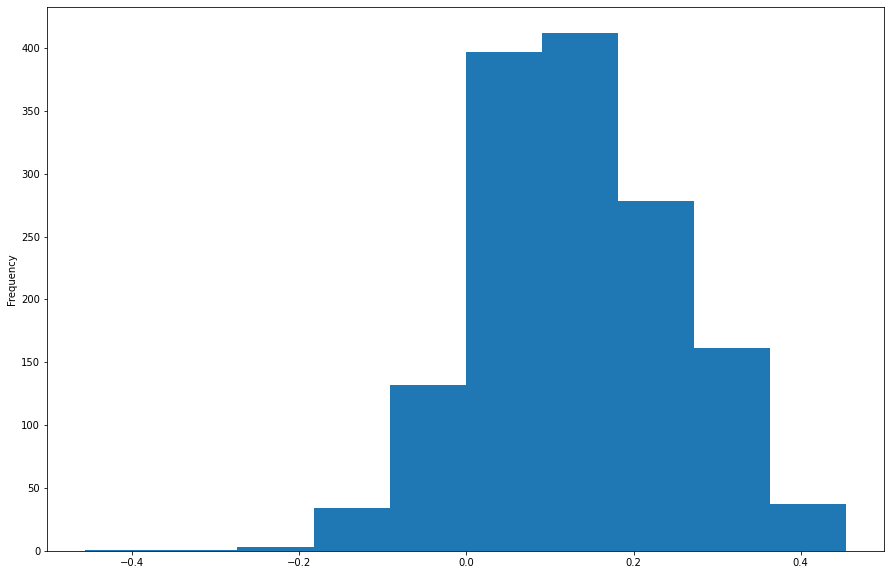

In [ ]:
df_train['ndvi_nw'].plot(kind="hist")

# Préparation data

In [ ]:
def missing_values_table(df):
    
    mis_val = df.isnull().sum()

    mis_val_percent = 100 * df.isnull().sum() / len(df)

    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)
    
    # Print some summary information
    print("Your selected dataframe has {} columns.".format(df.shape[1]) + '\n' + 
    "There are {} columns that have missing values.".format(mis_val_table_ren_columns.shape[0]))
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

missing_values_table(df_train)

#3 premiere voir le taux de corrélation avec la target , pour les supr  drop na pour les 3 premières et voir pour les autres 

Your selected dataframe has 25 columns.
There are 20 columns that have missing values.


,Missing Values,% of Total Values
ndvi_ne,194,13.32
ndvi_nw,52,3.57
station_diur_temp_rng_c,43,2.95
station_avg_temp_c,43,2.95
station_precip_mm,22,1.51
ndvi_sw,22,1.51
ndvi_se,22,1.51
station_max_temp_c,20,1.37
station_min_temp_c,14,0.96
precipitation_amt_mm,13,0.89


In [ ]:
df_train['ndvi_ne'].fillna((df_train['ndvi_ne'].mean()), inplace=True)
df_train['ndvi_nw'].fillna((df_train['ndvi_nw'].mean()), inplace=True)
df_train['station_diur_temp_rng_c'].fillna((df_train['station_diur_temp_rng_c'].mean()), inplace=True)
df_train['station_avg_temp_c'].fillna((df_train['station_avg_temp_c'].mean()), inplace=True)
df_train['ndvi_se'].fillna((df_train['ndvi_se'].mean()), inplace=True)
df_train['station_precip_mm'].fillna((df_train['station_precip_mm'].mean()), inplace=True)
df_train['ndvi_sw'].fillna((df_train['ndvi_sw'].mean()), inplace=True)
df_train['station_max_temp_c'].fillna((df_train['station_max_temp_c'].mean()), inplace=True)
df_train['station_min_temp_c'].fillna((df_train['station_min_temp_c'].mean()), inplace=True)
df_train['reanalysis_sat_precip_amt_mm'].fillna((df_train['reanalysis_sat_precip_amt_mm'].mean()), inplace=True)
df_train['precipitation_amt_mm'].fillna((df_train['precipitation_amt_mm'].mean()), inplace=True)
df_train['reanalysis_avg_temp_k'].fillna((df_train['reanalysis_avg_temp_k'].mean()), inplace=True)
df_train['reanalysis_dew_point_temp_k'].fillna((df_train['reanalysis_dew_point_temp_k'].mean()), inplace=True)
df_train['reanalysis_max_air_temp_k'].fillna((df_train['reanalysis_max_air_temp_k'].mean()), inplace=True)
df_train['reanalysis_min_air_temp_k'].fillna((df_train['reanalysis_min_air_temp_k'].mean()), inplace=True)
df_train['reanalysis_air_temp_k'].fillna((df_train['reanalysis_air_temp_k'].mean()), inplace=True)
df_train['reanalysis_relative_humidity_percent'].fillna((df_train['reanalysis_relative_humidity_percent'].mean()), inplace=True)
df_train['reanalysis_specific_humidity_g_per_kg'].fillna((df_train['reanalysis_specific_humidity_g_per_kg'].mean()), inplace=True)
df_train['reanalysis_tdtr_k'].fillna((df_train['reanalysis_tdtr_k'].mean()), inplace=True)
df_train['reanalysis_precip_amt_kg_per_m2'].fillna((df_train['reanalysis_precip_amt_kg_per_m2'].mean()), inplace=True)

In [ ]:
missing_values_table(df_train)

Your selected dataframe has 25 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [ ]:
def remove_constant_value_features(df):
    return [e for e in df.columns if df[e].nunique() == 1]

remove_constant_value_features(df_train)

[]

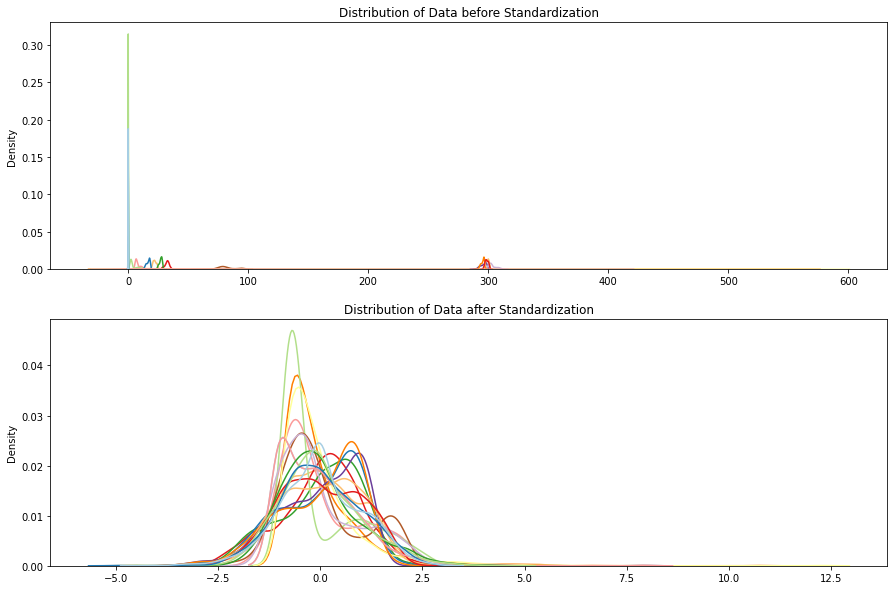

In [ ]:
keepCols = ['ndvi_ne', 	'ndvi_nw', 	'ndvi_se', 	'ndvi_sw', 	'precipitation_amt_mm', 	'reanalysis_air_temp_k', 	'reanalysis_avg_temp_k',	
'reanalysis_dew_point_temp_k', 	'reanalysis_max_air_temp_k', 	'reanalysis_min_air_temp_k', 	'reanalysis_precip_amt_kg_per_m2', 	
'reanalysis_relative_humidity_percent', 	'reanalysis_sat_precip_amt_mm', 	'reanalysis_specific_humidity_g_per_kg', 	'reanalysis_tdtr_k', 	
'station_avg_temp_c', 	'station_diur_temp_rng_c', 	'station_max_temp_c', 	'station_min_temp_c', 	'station_precip_mm']

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_train[keepCols])
scaled_df = pd.DataFrame(scaled_df, columns=keepCols)

plt.rcParams["figure.figsize"]=[15,10]
plt.subplot(211)
plt.title('Distribution of Data before Standardization')
sns.kdeplot(data=df_train[keepCols], legend=None, palette="Paired")
plt.subplot(212)
plt.title('Distribution of Data after Standardization')
sns.kdeplot(data=scaled_df, legend=None, palette="Paired")
plt.draw()

In [ ]:
scaled_df

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,-0.150582,-0.227748,-0.072330,-0.296607,-0.766360,-0.831817,-1.179627,-1.860722,-1.125607,0.070762,-0.188394,-1.234245,-0.766360,-1.778907,-0.643976,-1.369503,-0.553073,-1.569266,-1.342423,-0.495473
1,0.211087,0.098667,-0.565358,-0.562485,-0.527306,-0.361333,-0.622719,-0.850791,-0.784242,0.266407,-0.513331,-0.672584,-0.527306,-0.893869,-0.716759,-0.370479,-0.805235,-0.386830,0.062487,-0.652655
2,-0.841424,0.360068,-0.635739,-0.377986,-0.257911,0.058630,-0.276072,0.123473,-0.908375,0.618567,-0.324747,-0.015309,-0.257911,0.066472,-0.736976,-0.370479,-0.750713,-0.129779,0.445644,0.044046
3,-0.104450,0.972149,0.324452,0.403427,-0.698781,0.210195,0.002382,0.041815,-0.629076,0.501180,-0.606698,-0.256049,-0.698781,-0.047876,-0.700585,0.224446,-0.614409,0.435734,0.764941,-0.750363
4,0.412184,1.117600,0.647116,0.541037,-0.878991,0.601740,0.349028,0.377833,-0.473910,0.696825,-0.645986,-0.238810,-0.878991,0.301677,-0.534802,1.380620,0.625955,1.309708,1.148099,-0.712130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,1.532747,1.598946,0.717303,1.083754,0.219277,0.465962,1.229852,1.037667,1.946677,-0.477043,0.112045,0.926606,0.219277,1.131865,1.385852,1.137411,1.848145,1.515350,0.190206,-0.261823
1452,0.136590,0.253142,-0.924479,0.280542,0.935749,-0.273972,0.133084,0.792693,1.574279,-1.494394,3.858288,1.324299,0.935749,0.861333,0.726764,0.194512,1.164355,1.155478,-0.256811,-0.057910
1453,0.801052,0.131623,0.635613,0.377340,0.302946,-1.549648,-1.298965,0.167587,0.643284,-1.298750,0.241465,1.700343,0.302946,0.170594,0.734851,-2.188928,-0.553073,-0.129779,-1.853299,-0.678144
1454,1.465187,0.978132,1.024954,1.479867,0.319725,-1.735948,-1.355792,0.051201,0.829483,-1.494394,0.512553,1.753662,0.319725,0.045090,0.839982,-1.376987,0.321543,-0.643881,-0.703828,-0.495473


In [ ]:
trainlabels_df = pd.read_csv('/content/dengue_labels_train.csv')
trainlabels_df.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [ ]:
df_train2 = pd.concat([trainlabels_df,scaled_df],axis=1)
df_train2.head()

,city,year,weekofyear,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,4,-0.150582,-0.227748,-0.072330,-0.296607,-0.766360,-0.831817,-1.179627,-1.860722,-1.125607,0.070762,-0.188394,-1.234245,-0.766360,-1.778907,-0.643976,-1.369503,-0.553073,-1.569266,-1.342423,-0.495473
1,sj,1990,19,5,0.211087,0.098667,-0.565358,-0.562485,-0.527306,-0.361333,-0.622719,-0.850791,-0.784242,0.266407,-0.513331,-0.672584,-0.527306,-0.893869,-0.716759,-0.370479,-0.805235,-0.386830,0.062487,-0.652655
2,sj,1990,20,4,-0.841424,0.360068,-0.635739,-0.377986,-0.257911,0.058630,-0.276072,0.123473,-0.908375,0.618567,-0.324747,-0.015309,-0.257911,0.066472,-0.736976,-0.370479,-0.750713,-0.129779,0.445644,0.044046
3,sj,1990,21,3,-0.104450,0.972149,0.324452,0.403427,-0.698781,0.210195,0.002382,0.041815,-0.629076,0.501180,-0.606698,-0.256049,-0.698781,-0.047876,-0.700585,0.224446,-0.614409,0.435734,0.764941,-0.750363
4,sj,1990,22,6,0.412184,1.117600,0.647116,0.541037,-0.878991,0.601740,0.349028,0.377833,-0.473910,0.696825,-0.645986,-0.238810,-0.878991,0.301677,-0.534802,1.380620,0.625955,1.309708,1.148099,-0.712130


# Viz

In [ ]:
#Split des deux dataset selon la ville 
df_sj = df_train2[df_train2['city'] == 'sj']
df_iq = df_train2[df_train2['city'] == 'iq']

Text(0.5, 1.0, 'Corrélation sj')

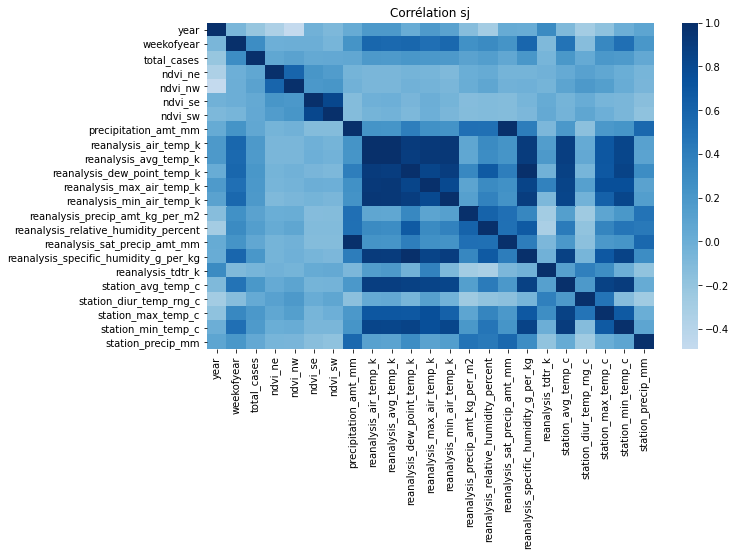

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_sj.corr(), center=0, cmap='Blues')
ax.set_title('Corrélation sj')

Text(0.5, 1.0, 'Corrélation iq')

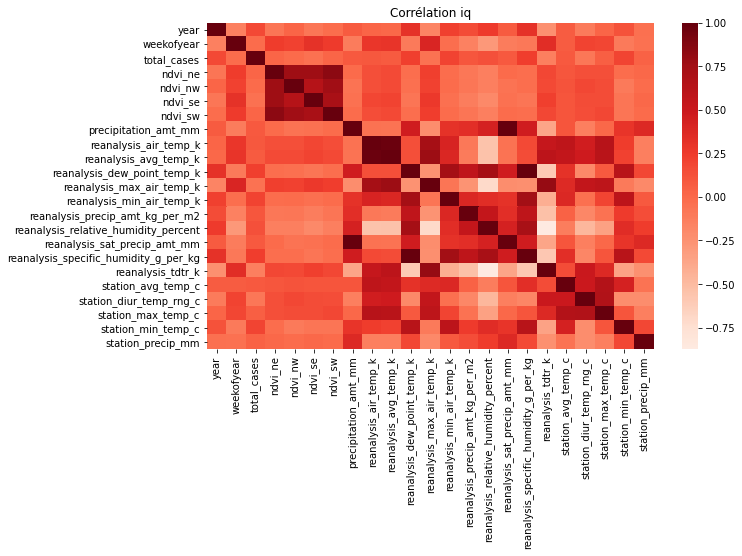

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_iq.corr(), center=0, cmap='Reds')
ax.set_title('Corrélation iq')

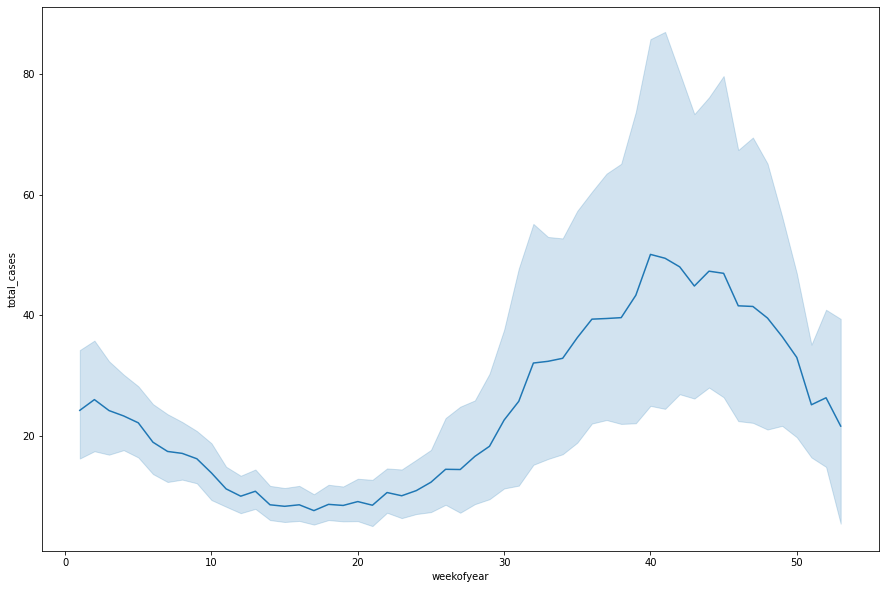

In [ ]:
sns.lineplot(x="weekofyear", y="total_cases",data=df_train2)

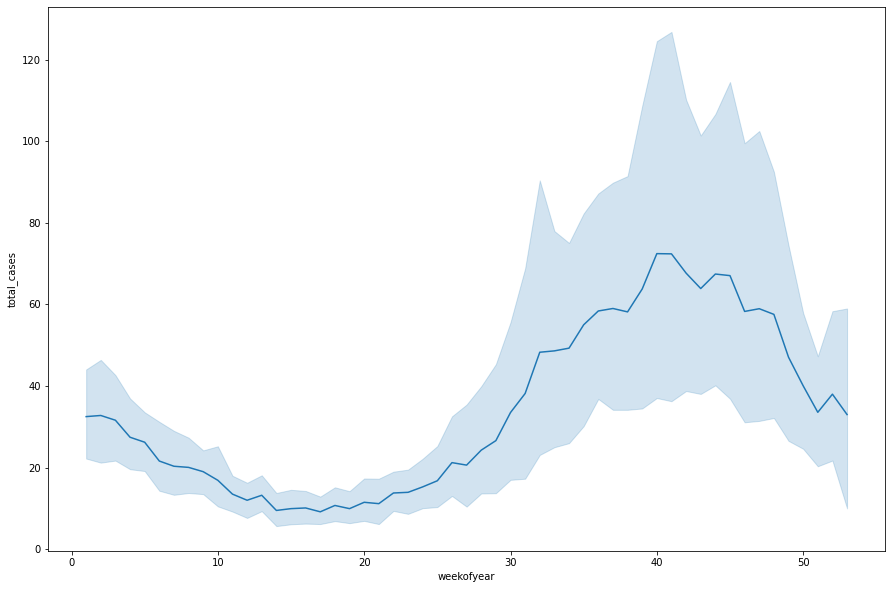

In [ ]:
sns.lineplot(x="weekofyear", y="total_cases",data=df_sj)

In [ ]:
df_sj.head()

,city,year,weekofyear,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,4,-0.150582,-0.227748,-0.072330,-0.296607,-0.766360,-0.831817,-1.179627,-1.860722,-1.125607,0.070762,-0.188394,-1.234245,-0.766360,-1.778907,-0.643976,-1.369503,-0.553073,-1.569266,-1.342423,-0.495473
1,sj,1990,19,5,0.211087,0.098667,-0.565358,-0.562485,-0.527306,-0.361333,-0.622719,-0.850791,-0.784242,0.266407,-0.513331,-0.672584,-0.527306,-0.893869,-0.716759,-0.370479,-0.805235,-0.386830,0.062487,-0.652655
2,sj,1990,20,4,-0.841424,0.360068,-0.635739,-0.377986,-0.257911,0.058630,-0.276072,0.123473,-0.908375,0.618567,-0.324747,-0.015309,-0.257911,0.066472,-0.736976,-0.370479,-0.750713,-0.129779,0.445644,0.044046
3,sj,1990,21,3,-0.104450,0.972149,0.324452,0.403427,-0.698781,0.210195,0.002382,0.041815,-0.629076,0.501180,-0.606698,-0.256049,-0.698781,-0.047876,-0.700585,0.224446,-0.614409,0.435734,0.764941,-0.750363
4,sj,1990,22,6,0.412184,1.117600,0.647116,0.541037,-0.878991,0.601740,0.349028,0.377833,-0.473910,0.696825,-0.645986,-0.238810,-0.878991,0.301677,-0.534802,1.380620,0.625955,1.309708,1.148099,-0.712130


# Random forest

Premier test avec un random forest regressor , sur nos données normalisées.

In [ ]:
#Importation des librairies 
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [ ]:
randomforest=RandomForestRegressor(n_estimators=30)

In [ ]:
X = df_sj.drop(['city','total_cases','weekofyear'], axis=1) 
y = df_sj['total_cases']

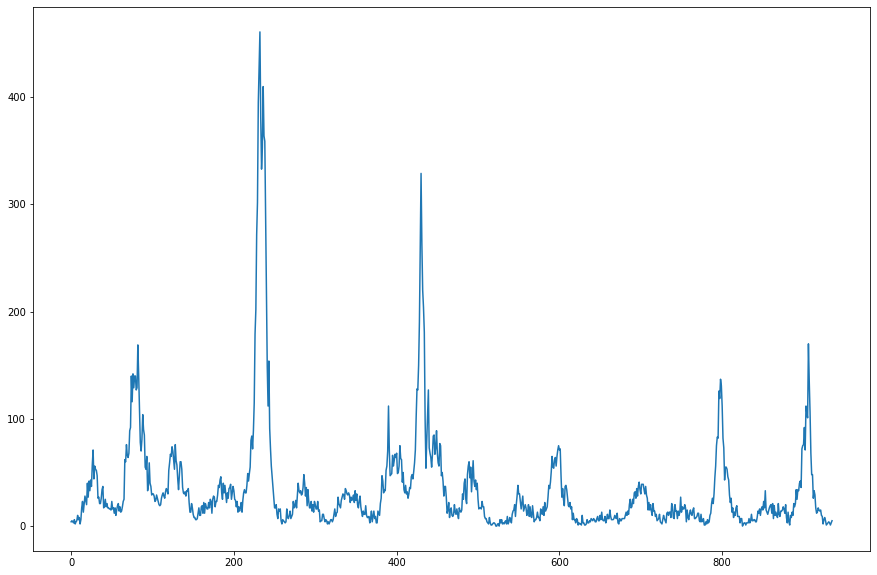

In [ ]:
plt.plot(y)

In [ ]:
randomforest.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
print(randomforest.score(X, y))

0.9550281858737747


In [ ]:
#On split le dataset en train & test 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=1)

In [ ]:
regressor = RandomForestRegressor(n_estimators=100, random_state=1,max_depth=None)
regressor.fit(X_train, y_train)
y_pred= regressor.predict(X_train)

In [ ]:
y_pred2=regressor.predict(X)

In [ ]:
#Les score sur le train et le test 
print(regressor.score(X_train, y_train))
print(regressor.score(X_test, y_test))

0.9604894364442133
0.4550221237037351


In [ ]:
y_train.shape

(655,)

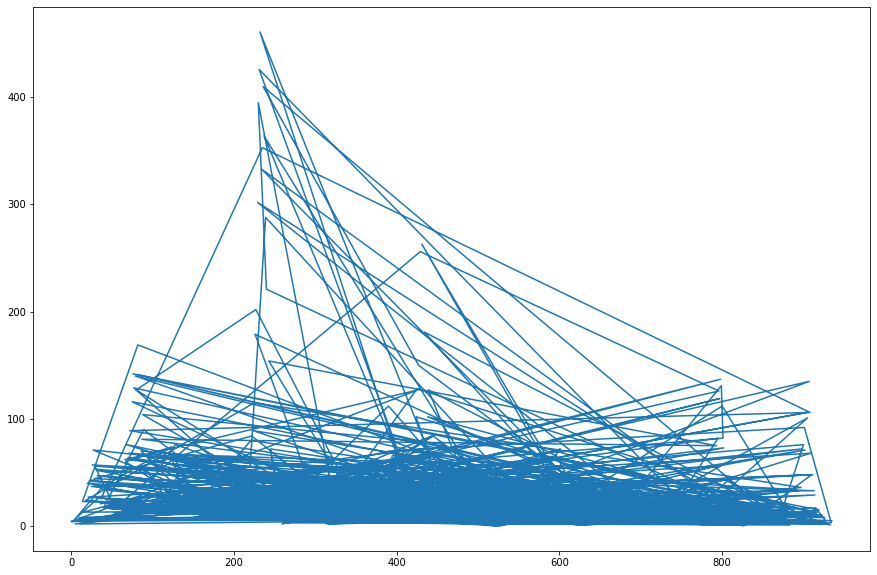

In [ ]:
plt.plot(y_train)

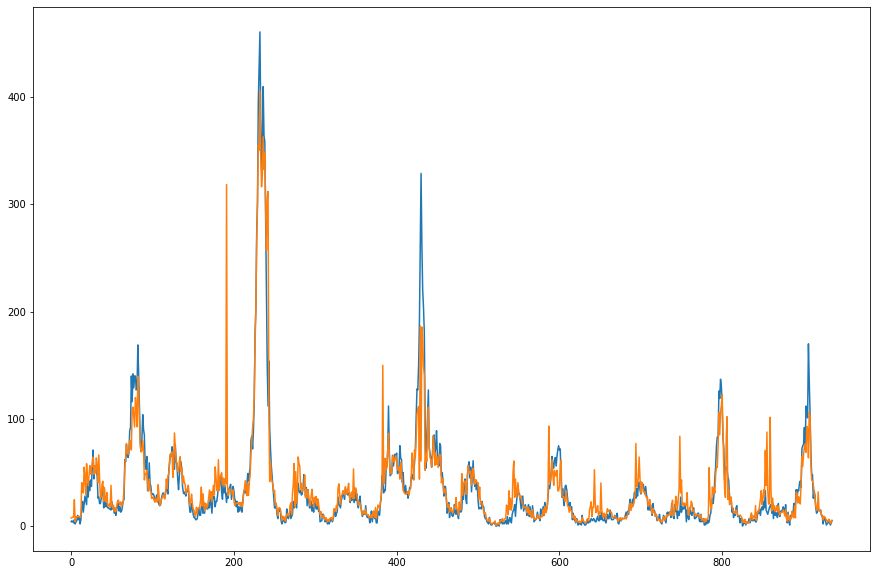

In [ ]:
plt.plot(y)
plt.plot(y_pred2)#Mettre ça au propre sur github et montrer les scores 

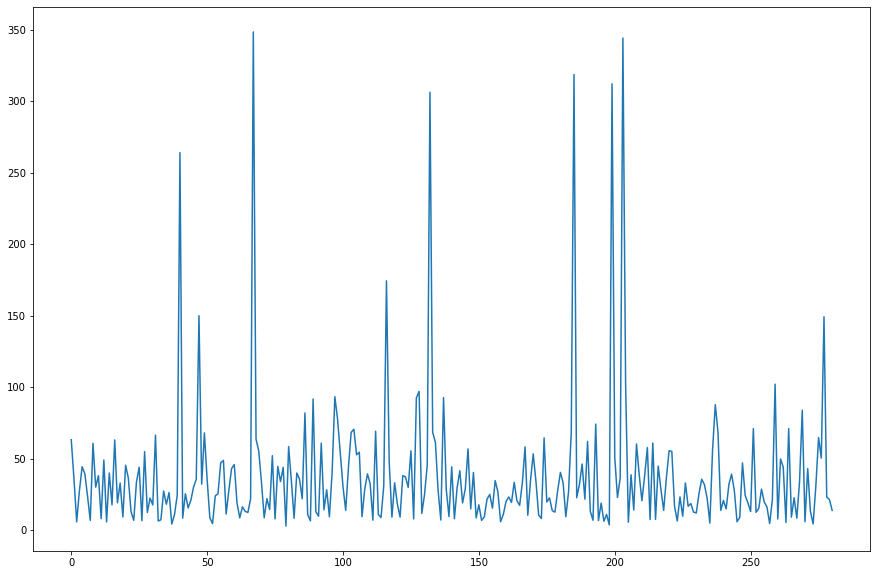

In [ ]:
plt.plot(y_pred)

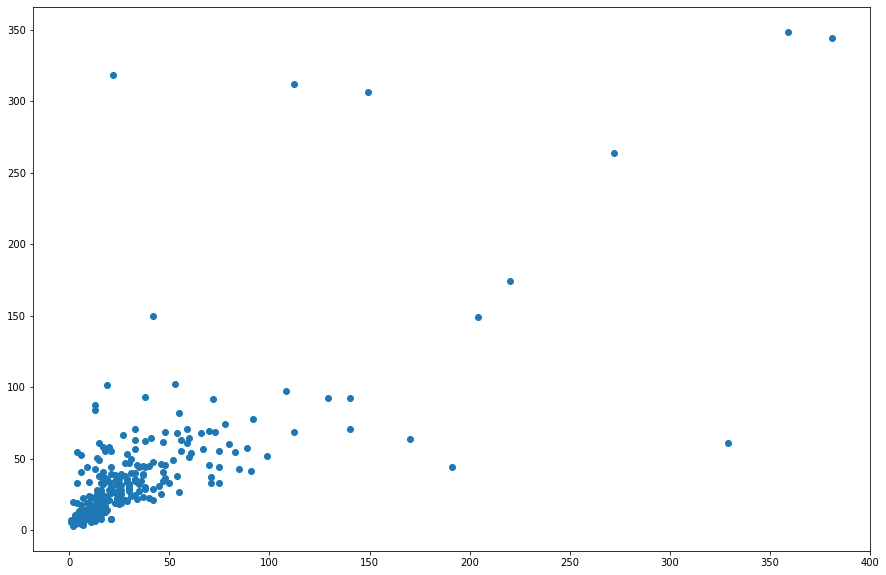

In [ ]:
plt.scatter(y_test.values, regressor.predict(X_test)) #Rien compris au graph 

In [ ]:
#On utilise la cross validation pour eviter un cas d'overfitting 
cross_val_score(randomforest, X, y, cv = 4)

array([-16.5305111 ,  -0.48604809,  -4.36242061,   0.23991506])

In [ ]:
#Voir la docu cross val score 
#le score moyen sur la cross validation est faible , alors que lorsqu'on split en TRAIN & TEST on a un meilleur score , je comprend pas..
score = cross_val_score(randomforest, X, y,cv=4, score="accuracy")
print ("Sur ce jeu de données, le score moyen  :",score.mean())
#Calcul de la prédiction du Random Forest pour le jeu de données X
y_predit=randomforest.predict(X)
print(X)

Sur ce jeu de données, le taux de succès en classification moyen de : -5.2688905513152
     year  weekofyear  ...  station_min_temp_c  station_precip_mm
0    1990          18  ...           -1.342423          -0.495473
1    1990          19  ...            0.062487          -0.652655
2    1990          20  ...            0.445644           0.044046
3    1990          21  ...            0.764941          -0.750363
4    1990          22  ...            1.148099          -0.712130
..    ...         ...  ...                 ...                ...
931  2008          13  ...           -0.639968          -0.797093
932  2008          14  ...            0.062487          -0.824706
933  2008          15  ...           -0.256811          -0.183232
934  2008          16  ...           -0.256811          -0.597429
935  2008          17  ...            0.764941          -0.828955

[936 rows x 22 columns]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

TEST KNN SCORE

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 13)
scoring = 'accuracy'
score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.03191489 0.06382979 0.05319149 0.05319149 0.05319149 0.06382979
 0.02150538 0.05376344 0.04301075 0.03225806]


In [ ]:
np.mean(score)*100

4.696865705788149

TEST DECISION TREE CL SCORE


In [ ]:
clf = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.06382979 0.03191489 0.03191489 0.03191489 0.03191489 0.03191489
 0.01075269 0.01075269 0.06451613 0.02150538]


In [ ]:
np.mean(score)*100

3.3093113703957897

TEST RANDOM FOREST CLASSIFIER SCORE


In [ ]:
clf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.0212766  0.06382979 0.0106383  0.0212766  0.03191489 0.03191489
 0.01075269 0.03225806 0.03225806 0.04301075]


In [ ]:
np.mean(score)*100

2.991306337222604

In [ ]:
clf = RandomForestRegressor(n_estimators=13)
score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1)
print(score)

[0.83156345 0.6319844  0.56305271 0.66626831 0.72609265 0.59995997
 0.44374689 0.77359525 0.63233693 0.51161307]


In [ ]:
np.mean(score)*100

63.80213628151758

Test Gaussian NB SCORE

In [ ]:
clf = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.03191489 0.0106383  0.0212766  0.         0.04255319 0.0106383
 0.03225806 0.05376344 0.01075269 0.01075269]


In [ ]:
np.mean(score)*100

2.2454815831617476

TEST SVC SCORE

In [ ]:
clf = SVC()
scoring = 'accuracy'
score = cross_val_score(clf, X, y, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.03191489 0.05319149 0.0212766  0.0212766  0.0212766  0.04255319
 0.01075269 0.02150538 0.02150538 0.01075269]


In [ ]:
np.mean(score)*100


2.560054907343857

RNN